<a href="https://colab.research.google.com/github/SophieWalden/ChessVision/blob/main/Final_Project_Sophie_Walden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempt #4: piece by piece detection

The problem with detecting the whole board at a time is that its hard to tell a model when it correctly gets one piece versus the other and how far it is away from telling certain pieces.

Here's how we tackle that:
Pre-process the images using the board corners to crop out where each piece should be. Use that data to predict what each piece is individually and then stitch them back together to create a whole boardstate.

This will still get the desired result on whole boards by doing 64 predictions, one for each square. It just means that we simplified this down to just a multiclass classification problem instead of making an overcomplicated nightmare model

Basically focus more on preprocessing and create a simpler model overall

In [ ]:
import os

# Downloading Dataset

from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir /usr/local/dataset

# You can check if everything's okay by running this command.
! kaggle datasets list

# Download and unzip sign-language-mnist dataset into '/usr/local'
! kaggle datasets download -d thefamousrat/synthetic-chess-board-images --path '/usr/local/dataset' --unzip

! mkdir /usr/local/dataset/test
! mkdir /usr/local/dataset/train


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/usr/local/dataset’: File exists
ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                              29MB  2023-11-16 01:38:36           1001        112  1.0              
muhammadbinimran/housing-price-prediction-data                 Housing Price Prediction Data                      763KB  2023-11-21 17:56:32           3685         75  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset

In [ ]:
import os


import shutil

dataset_size = 1942
training_split = 0.4
test_split = 0.5
path = "/usr/local/dataset/data"
for file_name in sorted(list(os.walk(path))[-1][-1], key=lambda x: x[-4:]):
  if file_name != "config.json":
    path_name = f"{path}/{file_name}"

    number = int(file_name[:file_name.index(".")])

    if number < dataset_size * training_split:
      shutil.move(path_name, f"/usr/local/dataset/train/{file_name}")
    elif number < dataset_size * test_split:
      shutil.move(path_name, f"/usr/local/dataset/test/{file_name}")


In [ ]:
import json
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

def findIntersection(p1, p2, p3, p4):
    """
      Finds the point at which two lines (p1, p2) and (p3, p4) intersect
      Math taken from https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
    """
    try:
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        x4, y4 = p4

        uA = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / ((y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1))
        uB = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / ((y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1))
        if 0 <= uA <= 1 and 0 <= uB <= 1:
            intersectionX = x1 + (uA * (x2 - x1))
            intersectionY = y1 + (uA * (y2 - y1))
            return [intersectionX, intersectionY]
    except Exception:
        return None


def rotate_board_by_corners(image, corners):
    """
      Given an image and its the corners of an object, this function warps it
      Such that the object is now rotated flat and the image is cropped just to the object
      Code from: https://www.kaggle.com/code/thefamousrat/synthetic-chess-pieces-predictions
    """

    width, height = image.shape[0], image.shape[1]
    boardCornersRel = np.array(corners)
    boardCornersRel = np.column_stack((boardCornersRel[:,0], 1.0 - boardCornersRel[:,1]))
    intersection = findIntersection(boardCornersRel[0], boardCornersRel[3], boardCornersRel[1], boardCornersRel[2])

    for i in range(4):
        boardCornersRel[i] = 0.1 * (boardCornersRel[i] - intersection) + boardCornersRel[i]

    cornersAbs = np.round(boardCornersRel * (np.array(image.shape)[0:2] - np.array([1.0, 1.0])))



    input_pts = np.float32(cornersAbs)

    output_pts = np.float32([
                          [width - 1, 0],
                          [width - 1, height - 1],
                          [0, 0],
                          [0, height - 1]])

    M = cv2.getPerspectiveTransform(input_pts, output_pts)
    image = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)

    return image


In [ ]:

def get_piece(piece_map, square_index):
  index = "ABCDEFGH"[square_index - (square_index // 8) * 8 ] + str(square_index // 8 + 1)

  if index not in piece_map:
    return "empty"
  else:
    return piece_map[index]

classes = {"empty": 0, "king_w": 1, "king_b": 2, "rook_w": 3, "rook_b": 4, "pawn_b": 5, "pawn_w": 6, "bishop_w": 7, "bishop_b": 8, "queen_w": 9, "queen_b": 10, "knight_w": 11, "knight_b": 12}
num_of_classes = len(classes)


def get_images_and_jsons(path):
  # Takes a path to a directory with images/json pairs and splits them and returns them sorted by name
  images, jsons = [], []
  for file_name in list(os.walk(path))[0][2]:
    path_name = f"{path}/{file_name}"

    if file_name[-4:] == "json":
      jsons.append(path_name)
    else:
      images.append(path_name)

  images.sort()
  jsons.sort()

  return images, jsons

def process_images(path, img_arr, label_arr):
  """

    Takes a path to a directory of images/json pairs and cuts them down into 64 piece images labeled separately

    Params:
      - Path: path to directory
      - img_arr: array to save cut images to
      - label_arr: array to save labels to

  """

  empty_images = 2000

  images, jsons = get_images_and_jsons(path)

  # Loop through every image/json pair
  for image_name, json_name in zip(images, jsons):

    # Load in json / image
    json_file = json.load(open(json_name))
    image = cv2.imread(image_name)
    config, corners = json_file["config"], json_file["corners"]
    width, height = image.shape[0], image.shape[1]

    # Standardize the board by rotating so every image is facing the same direction
    image = rotate_board_by_corners(image, corners)
    margins_x, margins_y = 0.05 * image.shape[0], 0.05 * image.shape[1]
    tile_size_x, tile_size_y = (image.shape[0] - margins_x * 2) // 8, (image.shape[1] - margins_y * 2) // 8

    # split the 64 squares up from the image
    for j in range(8):
      for i in range(8):
        rect_p1, rect_p2 = [tile_size_x * i + margins_x, tile_size_y * j + margins_y], [tile_size_x * (1 + i) + margins_x, tile_size_y * (1 + j) + margins_y]
        rect_p1, rect_p2 = list(map(int, rect_p1)), list(map(int, rect_p2))

        if get_piece(config, i + j * 8) == "empty":
          empty_images -= 1

          if empty_images < 0:
            continue

        # Create a label array based on what the json provided was in the spot
        label = [0] * num_of_classes
        label[classes[get_piece(config, i + j * 8)]] = 1
        label_arr.append(label)


        # Append the image to the provided array
        img_arr.append(image[rect_p1[0]:rect_p2[0], rect_p1[1]:rect_p2[1]])



x_train, y_train = [], []
process_images("/usr/local/dataset/train", x_train, y_train)

x_test, y_test = [], []
process_images("/usr/local/dataset/test", x_test, y_test)

img_size = (224, 224, 3)
batch_size = 32

In [ ]:
import random
from keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224, 3)
batch_size = 32

def custom_data_generator(images, labels, datagen, batch_size):
    while True:
        batch_images = []
        batch_labels = []

        for i in range(batch_size):
            # Pick random image and label
            index = random.randint(0, len(images) - 1)
            img, label = images[index], labels[index]

            # load image and setup
            img = cv2.resize(img, img_size[:2])

            # Add back to btach
            batch_images.append(img)
            batch_labels.append(label)

        yield np.array(batch_images), np.array(batch_labels)

test_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator()

train_generator = custom_data_generator(x_train, y_train, train_datagen, batch_size)
test_generator = custom_data_generator(x_test, y_test, test_datagen, batch_size)

In [ ]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf


# Define base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_size)
base_model.trainable = False

inputs = keras.Input(shape=img_size)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Add fully connected and dropout layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(num_of_classes, activation='softmax')(x)

model = Model(inputs, outputs=predictions)

16705208/16705208 [==============================] - 0s 0us/step


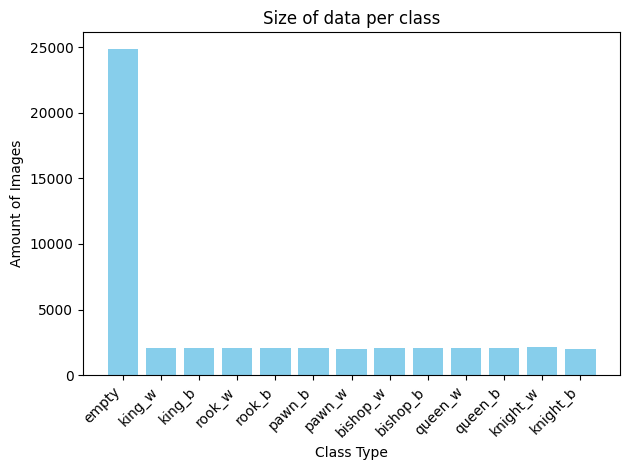

In [ ]:
# Amount of each class of Data:
a = [0] * num_of_classes


for value in y_train:
  index = value.index(1)
  a[index] += 1

from matplotlib import pyplot as plt
plt.bar(list(classes.keys()), a, color='skyblue')

# Set chart title and labels
plt.title('Size of data per class')
plt.xlabel('Class Type')
plt.ylabel('Amount of Images')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the chart
plt.show()

In [ ]:


optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss= tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs=50,
    validation_data=test_generator,
    validation_steps = 50,
    verbose = 1
)

Epoch 1/50
100/100 [==============================] - 33s 132ms/step - loss: 2.3670 - categorical_accuracy: 0.1681 - val_loss: 1.7267 - val_categorical_accuracy: 0.3894
Epoch 2/50
100/100 [==============================] - 12s 116ms/step - loss: 1.9831 - categorical_accuracy: 0.2856 - val_loss: 1.4709 - val_categorical_accuracy: 0.4444
Epoch 3/50
100/100 [==============================] - 12s 117ms/step - loss: 1.7553 - categorical_accuracy: 0.3453 - val_loss: 1.2463 - val_categorical_accuracy: 0.5525
Epoch 4/50
100/100 [==============================] - 9s 94ms/step - loss: 1.5509 - categorical_accuracy: 0.4244 - val_loss: 1.1355 - val_categorical_accuracy: 0.5663
Epoch 5/50
100/100 [==============================] - 12s 123ms/step - loss: 1.3938 - categorical_accuracy: 0.4647 - val_loss: 1.0729 - val_categorical_accuracy: 0.6075
Epoch 6/50
100/100 [==============================] - 12s 121ms/step - loss: 1.2628 - categorical_accuracy: 0.5334 - val_loss: 0.9256 - val_categorical_accur

In [ ]:
model.save_weights("/usr/model.keras")

In [ ]:
base_model.trainable = True

optimizer = tf.keras.optimizers.Adam(1e-5)
model.compile(optimizer=optimizer, loss= tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
])

# Retrain to fine-tune
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=test_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/30
100/100 [==============================] - 30s 305ms/step - loss: 0.1035 - categorical_accuracy: 0.9703 - val_loss: 0.2139 - val_categorical_accuracy: 0.9500
Epoch 2/30
100/100 [==============================] - 30s 302ms/step - loss: 0.1038 - categorical_accuracy: 0.9672 - val_loss: 0.1994 - val_categorical_accuracy: 0.9563
Epoch 3/30
100/100 [==============================] - 30s 300ms/step - loss: 0.1122 - categorical_accuracy: 0.9659 - val_loss: 0.1742 - val_categorical_accuracy: 0.9494
Epoch 4/30
100/100 [==============================] - 30s 302ms/step - loss: 0.1322 - categorical_accuracy: 0.9563 - val_loss: 0.1853 - val_categorical_accuracy: 0.9456
Epoch 5/30
100/100 [==============================] - 30s 302ms/step - loss: 0.0857 - categorical_accuracy: 0.9744 - val_loss: 0.2352 - val_categorical_accuracy: 0.9431
Epoch 6/30
100/100 [==============================] - 30s 301ms/step - loss: 0.0861 - categorical_accuracy: 0.9756 - val_loss: 0.1642 - val_categorical_acc

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


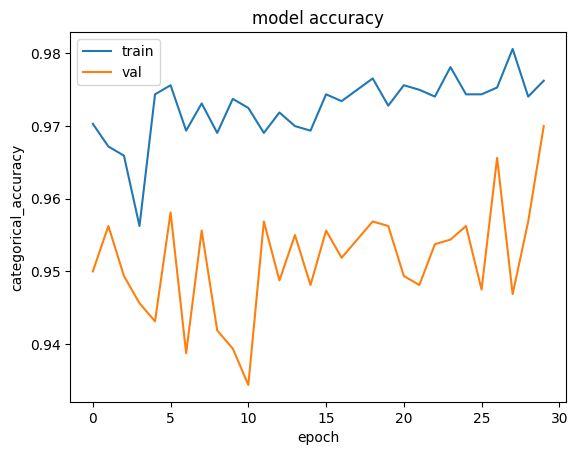

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

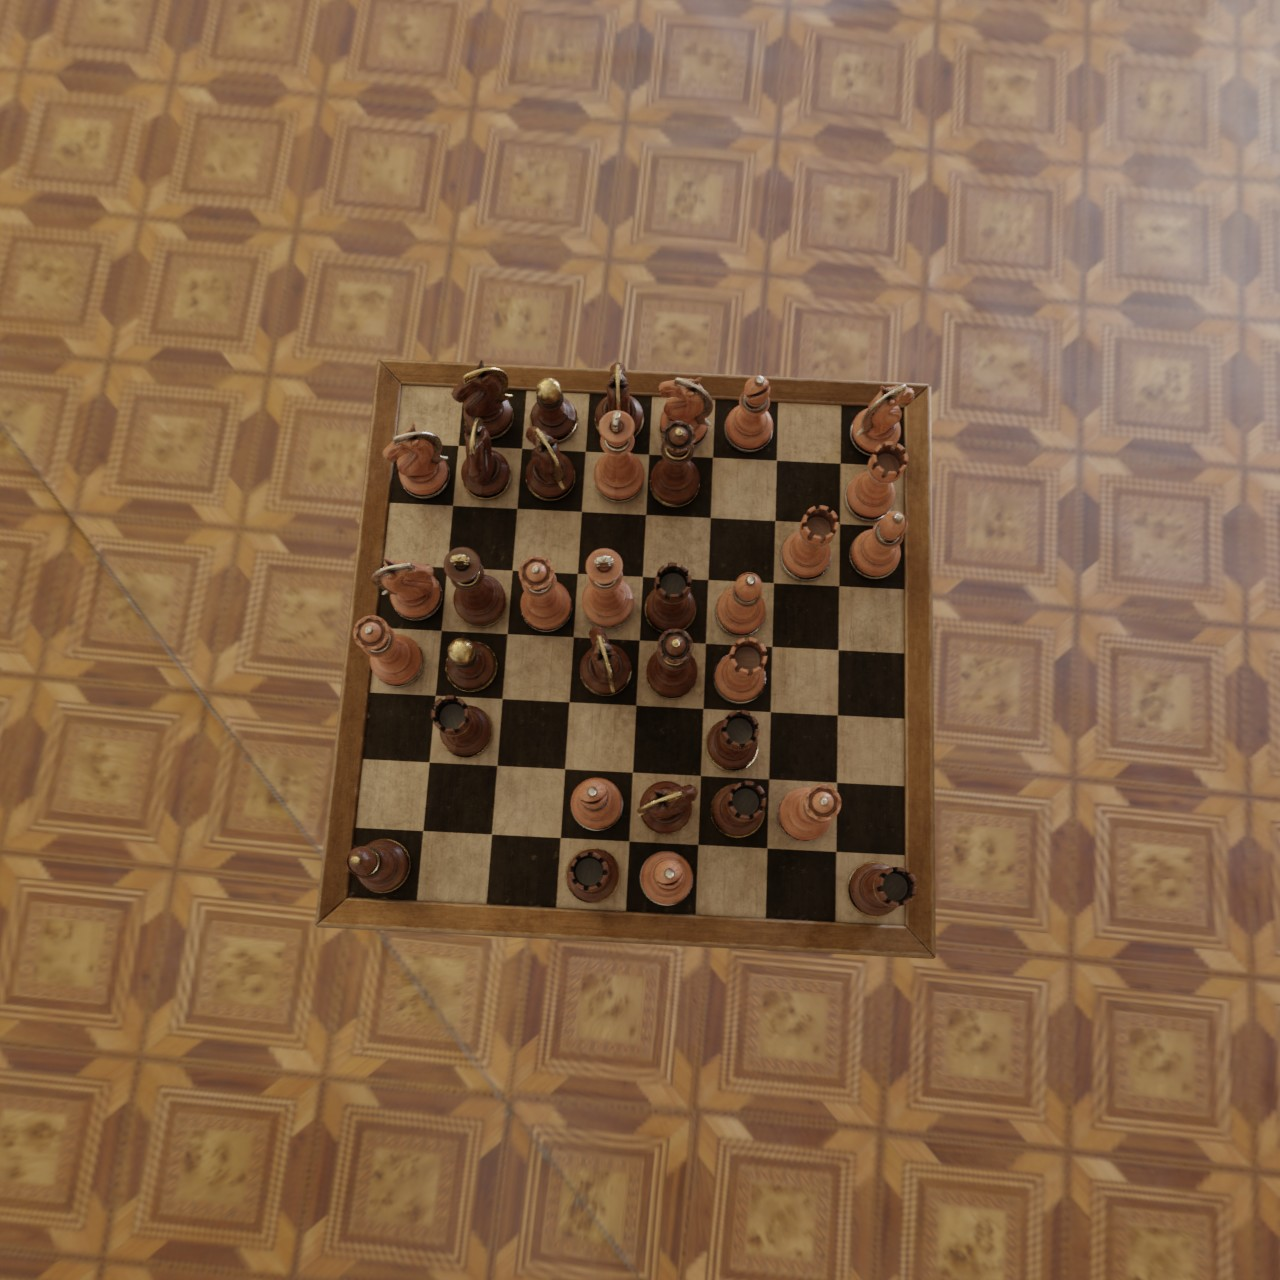

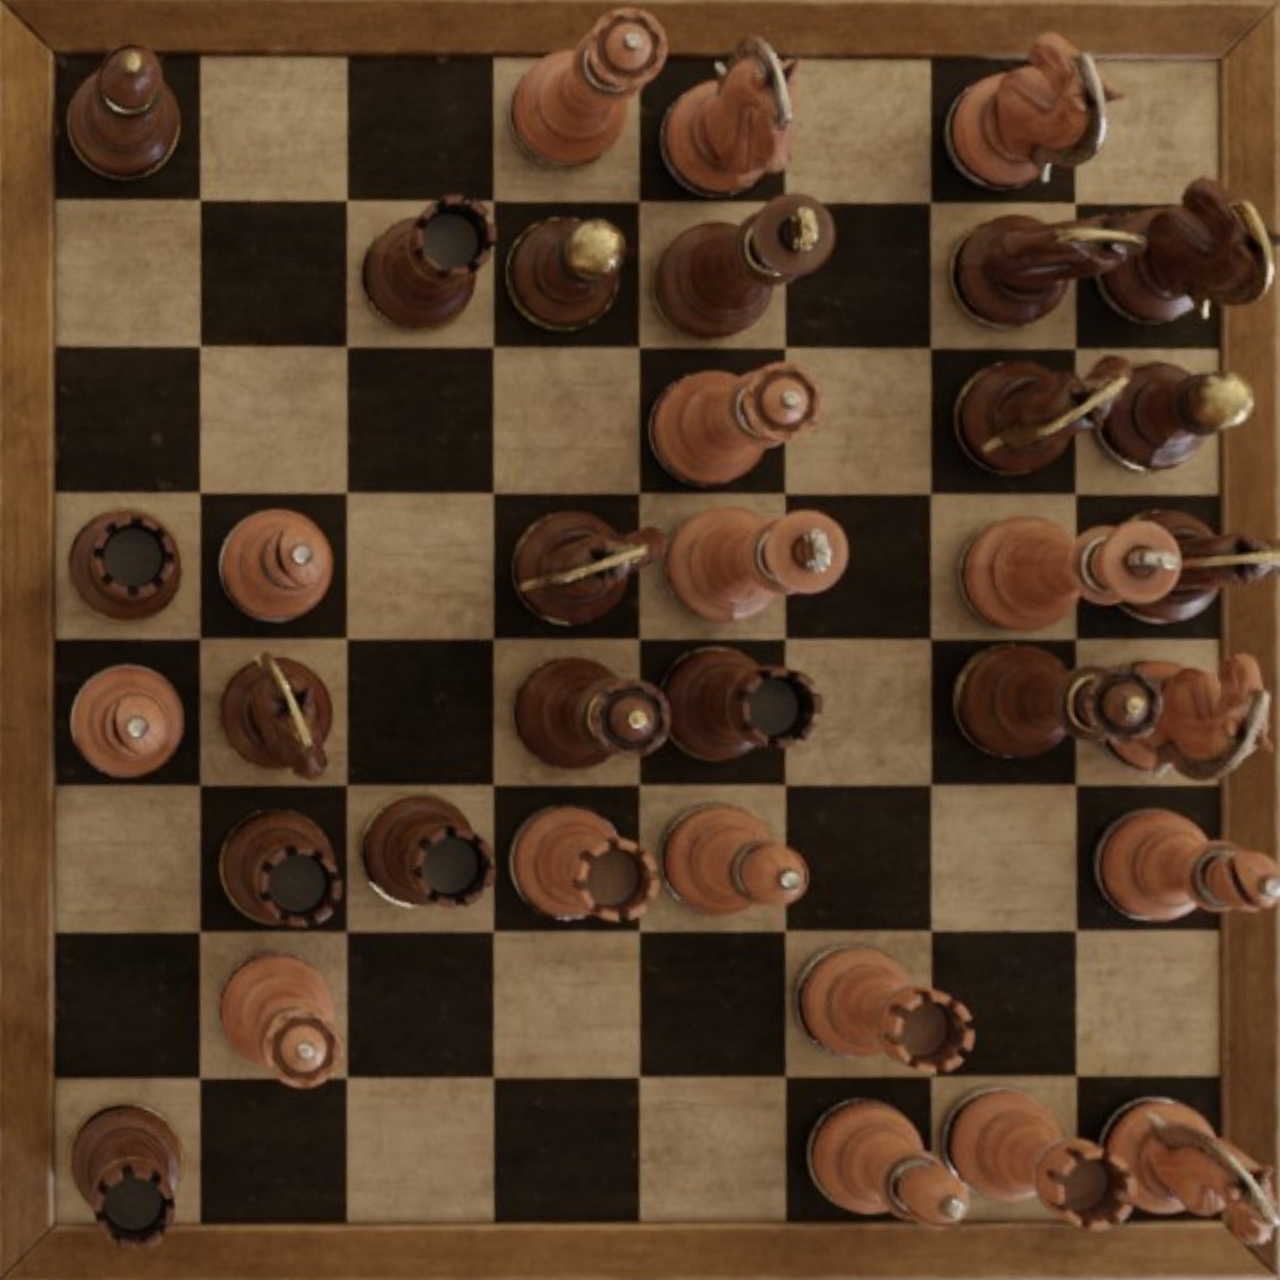

B _ _ R b _ _ R
_ _ _ b N R k _
_ R _ _ _ R _ _
q P _ N Q r _ _
n K q k R b _ _
_ _ _ _ _ _ r b
n N N k Q _ _ r
_ N P n n b _ n
https://lichess.org/analysis/1npNNB1N/NnnKq2R/6RB/NkQKrB2/Qp1nqR2/1r3r2/3BnrK1/b2rB2r/


In [ ]:
from json import load

def get_piece(piece_map, square_index):
  index = "ABCDEFGH"[square_index - (square_index // 8) * 8 ] + str(square_index // 8 + 1)

  if index not in piece_map:
    return "empty"
  else:
    return piece_map[index]

classes = {"empty": 0, "king_w": 1, "king_b": 2, "rook_w": 3, "rook_b": 4, "pawn_b": 5, "pawn_w": 6, "bishop_w": 7, "bishop_b": 8, "queen_w": 9, "queen_b": 10, "knight_w": 11, "knight_b": 12}

num_of_classes = len(classes)


def test_image(img_path, json_path):
  """

    Takes a path to a directory of images/json pairs and cuts them down into 64 piece images labeled separately

    Params:
      - Path: path to directory
      - img_arr: array to save cut images to
      - label_arr: array to save labels to

  """


  # Load in json / image
  image = cv2.imread(img_path)
  json_file = load(open(json_path))

  config, corners = json_file["config"], json_file["corners"]
  width, height = image.shape[0], image.shape[1]

  # Standardize the board by rotating so every image is facing the same direction
  image = rotate_board_by_corners(image, corners)
  margins_x, margins_y = 0.05 * image.shape[0], 0.05 * image.shape[1]
  tile_size_x, tile_size_y = (image.shape[0] - margins_x * 2) // 8, (image.shape[1] - margins_y * 2) // 8

  cv2_imshow(image)

  # split the 64 squares up from the image
  pieces = []
  for j in range(8):
    temp_list = []
    for i in range(8):
      rect_p1, rect_p2 = [tile_size_x * i + margins_x, tile_size_y * j + margins_y], [tile_size_x * (1 + i) + margins_x, tile_size_y * (1 + j) + margins_y]
      rect_p1, rect_p2 = list(map(int, rect_p1)), list(map(int, rect_p2))

      # Append the image to the provided array
      piece_img = cv2.resize(image[rect_p1[0]:rect_p2[0], rect_p1[1]:rect_p2[1]], img_size[:2])
      piece_img = np.expand_dims(piece_img, axis=0)  # Add batch dimension

      output = model.predict(piece_img, verbose=0)
      index = np.argmax(output)
      temp_list.append(list(classes.keys())[index])

    pieces.append(temp_list)

  return pieces

image, json_name = "/usr/local/dataset/train/1.jpg", "/usr/local/dataset/train/1.json"


cv2_imshow(cv2.imread(image))
pieces = test_image(image, json_name)

ascii = {"empty": "_", "king_w": "k", "king_b": "K", "rook_w": "r", "rook_b": "R", "pawn_b": "P", "pawn_w": "p", "bishop_w": "b", "bishop_b": "B", "queen_w": "q", "queen_b": "Q", "knight_w": "n", "knight_b": "N"}
for row in pieces:
  print(*[f"{ascii[tile]:1s}" for tile in row])

def piecesToFEN(pieces):
  retVal = ""
  for j, row in enumerate(pieces[::-1]):
    emptyInARow = 0
    for i, tile in enumerate(row):

      if tile != "empty":
        if emptyInARow:
          retVal += str(emptyInARow)
          emptyInARow = 0

        retVal += ascii[tile].upper() if ascii[tile].islower() else ascii[tile].lower()
      else:
        emptyInARow += 1

    if emptyInARow: retVal += str(emptyInARow)

    retVal += "/"

  return retVal

fen = piecesToFEN(pieces)
link = f"https://lichess.org/analysis/{fen}"

print(link)


